## 쉽고 빠른 분석을 위해, 큰 데이터를 줄여보기

- 데이터가 당최 커서, 조인 / 정렬 등의 데이터 전처리에 한 세월 ;
- 데이터를 줄이고 싶은데, 어떤 비율로 줄여야 줄이기 전 데이터의 정보량을 최대한 담고 있다. 라고 말할 수 있을까?

---

## openml 에서 데이터를 가지고 와서, 이 주제에 대한 고민을 해 보자구요.

- openml (https://www.openml.org/)
- Democratizing Machine Learning 이라는 기조하에, 여러 유형의 '문제' 및 그에 상응하는 '데이터' / '풀이방법' 까지를 모으고 있는 사이트
- https://github.com/openml/OpenML/wiki/Data-Repositories 에서도 언급하다시피, 굉장히 다양한 유형의 데이터를 모으기 위한 시도를 함

---

- 그래서, 데이터를 얻는 방법 : https://github.com/openml/openml-python/blob/master/examples/OpenML_Tutorial.ipynb

In [2]:
# 가져왔습니다. 데이터!
import glob
fs = glob.glob("./binary/*")
print("파일 수 : {}".format(len(fs)))
fs

파일 수 : 30


['./binary/adult.csv',
 './binary/appendicitis.csv',
 './binary/australian.csv',
 './binary/banana.csv',
 './binary/bands.csv',
 './binary/breast.csv',
 './binary/bupa.csv',
 './binary/chess.csv',
 './binary/coil2000.csv',
 './binary/crx.csv',
 './binary/german.csv',
 './binary/haberman.csv',
 './binary/heart.csv',
 './binary/hepatitis.csv',
 './binary/housevotes.csv',
 './binary/ionosphere.csv',
 './binary/magic.csv',
 './binary/mammographic.csv',
 './binary/mushroom.csv',
 './binary/phoneme.csv',
 './binary/pima.csv',
 './binary/ring.csv',
 './binary/saheart.csv',
 './binary/sonar.csv',
 './binary/spambase.csv',
 './binary/spectfheart.csv',
 './binary/titanic.csv',
 './binary/twonorm.csv',
 './binary/wdbc.csv',
 './binary/wisconsin.csv']

## 데이터의 사이즈를 한번 봅시다.

- adult.csv 가 5.5메가로 가장 크군요.
- 자, 그럼 행/열이 어떻게 되는 지 살펴봅시다.

In [12]:
# 각 데이터의 사이즈를 한번 보죠 => adult.csv 가 가장 크네요
!ls -al ./binary/* | sort -r

-rw-r--r--  1 andrew.lee  staff  5747432  5  2 18:57 ./binary/adult.csv
-rw-r--r--  1 andrew.lee  staff  1746135  5  2 18:57 ./binary/coil2000.csv
-rw-r--r--  1 andrew.lee  staff  1701567  5  2 18:57 ./binary/magic.csv
-rw-r--r--  1 andrew.lee  staff  1189576  5  2 18:57 ./binary/spambase.csv
-rw-r--r--  1 andrew.lee  staff  1144344  5  2 18:57 ./binary/twonorm.csv
-rw-r--r--  1 andrew.lee  staff  1045438  5  2 18:57 ./binary/ring.csv
-rw-r--r--  1 andrew.lee  staff   287035  5  2 18:57 ./binary/mushroom.csv
-rw-r--r--  1 andrew.lee  staff   286171  5  2 18:57 ./binary/phoneme.csv
-rw-r--r--  1 andrew.lee  staff   261044  5  2 18:57 ./binary/chess.csv
-rw-r--r--  1 andrew.lee  staff   146336  5  2 18:57 ./binary/wdbc.csv
-rw-r--r--  1 andrew.lee  staff   134937  5  2 18:57 ./binary/banana.csv
-rw-r--r--  1 andrew.lee  staff   116424  5  2 18:57 ./binary/sonar.csv
-rw-r--r--  1 andrew.lee  staff    96265  5  2 18:57 ./binary/ionosphere.csv
-rw-r--r--  1 andrew.lee  staff    95929  5  2 

## 4만5천라인에 16개의 칼럼이 있는 나름 큰 데이터셋입니다.

In [382]:
import pandas as pd
df = pd.read_csv("./binary/adult.csv", sep = ",", header = 0, error_bad_lines = False)
df.shape

(45222, 16)

## 자, 그럼 어떻게 데이터를 줄이면, 줄이기 전 데이터의 정보량을 최대한 담고 있다라고 할 수 있을까요?

- 이 말을 다르게 풀면,

---

## 줄이기 전 데이터와 같다 혹은 다르다. 라고 평가할 수 있는 메트릭이 무엇일까요?

- 1) 일단 변수 별로 K-L Divergence 를 볼 수 있을 거 같아요.
    - 줄이기 전 데이터와 같다 = 변수 별로 각각의 분포가 있을 텐데, 그 분포들이 샘플링한 집단의 각 변수들의 분포와 비교했을 때 큰 차이가 없다. 를 의미할테니까요.


- 2) 그리고, 똑같이 N by N 차원으로 Dimension Reduction 을 하고, 그것을 다시 flatten 한 후, 두 벡터 간 Distance 를 구해보면 같다 / 다르다를 측정할 수 있지 않을까요?
    - 만약 두 집단(줄이기 전 상황과 줄인 후 상황)의 성질이 비슷하다면, Distance = 0 에 수렴하지 않을까요?

## 1) 우선 1번 방법을 적용해보죠

In [383]:
# 우선 1번 방법을 적용해보는 겁니다.
# kl-divergence 를 구할 수 있도록 함수를 만든 후에!
import numpy as np
import pandas as pd
from scipy import stats

def kl(P,Q):
    """ Epsilon is used here to avoid conditional code for
    checking that neither P nor Q is equal to 0. """
    epsilon = 0.00001

    # You may want to instead make copies to avoid changing the np arrays.
    P = P+epsilon
    Q = Q+epsilon

    divergence = np.sum(P*np.log(P/Q))
    return divergence

def _get_kl_metric(df1, df2, col, dtype, bin_size = None):
    df1_s = df1[col].value_counts(normalize = True)
    df2_s = df2[col].value_counts(normalize = True)
    return kl(df1_s, df2_s)

# 샘플링 비율은 10% ~ 90% 까지 9개의 등분을 한 것을 대상으로 합시다.
def _divergence(df):
    from tqdm import tqdm
    cols = [col for col in df.columns if col not in ['Unnamed: 0']]
    samples = []
    ret = []
    import numpy as np
    # 딱 한 번 하고 평가할 수는 없으니까, 10번의 라운드를 토대로 k-l divergence 의 분포를 보도록 하죠
    for ining in tqdm(range(10)):
        for ratio in (np.arange(0.1, 1, 0.1)):
            sample_df = df[cols].sample(frac = ratio)
            samples.append({
                "sample_ratio" : ratio,
                "sample"       : sample_df
            })
            # calculate k-l divergence
            ret_kl = []
            for col in df[cols].columns:
                tmp = {
                    'col' : col,
                    'kl'  : _get_kl_metric(sample_df, df[cols], col, df[cols][col].dtypes)
                }
                ret_kl.append(tmp)
            ret_kl = pd.DataFrame(ret_kl)
            ret_kl.kl = ret_kl.kl.apply(lambda x : 0 if x == np.inf else x)
            ret_kl.sort_values('kl', ascending = False)
            # append result to ret
            ret.append({
                "ining"        : ining,
                "sample_ratio" : ratio,
                "kl_div"       : ret_kl.kl.mean()
            })
    return ret
ret = _divergence(df)

100%|██████████| 10/10 [00:23<00:00,  2.37s/it]


## 결과를 봅시다

- 뭔가 수렴하는 sample ratio 를 눈으로 볼 수 있느냐? => 아래 그래프로는 쉽지 않네요.
- 즉, sample_ratio 를 .5 로 할 것이냐, .6으로 할 것이냐 등을 결정할 수 있는 clue 가 없는 것 같아요.

,sample_ratio,kl_div
0,0.1,0.106486
1,0.2,0.067946
2,0.3,0.048013
3,0.4,0.034879
4,0.5,0.025508
5,0.6,0.018191
6,0.7,0.012368
7,0.8,0.007559
8,0.9,0.003491


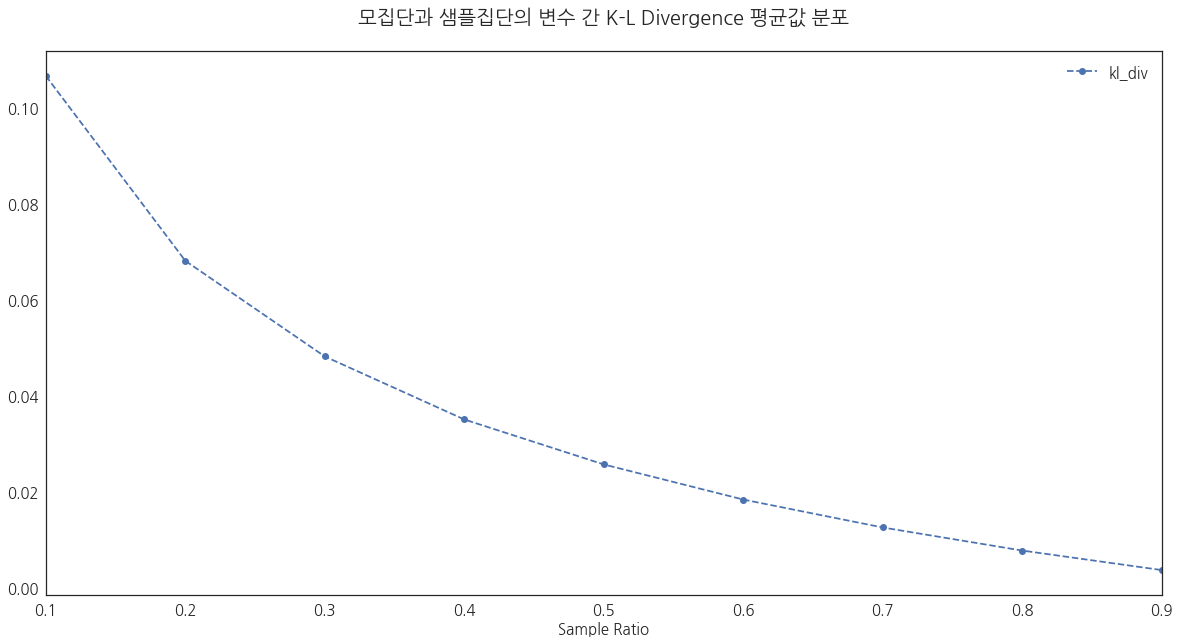

In [384]:
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['font.family'] = 'NanumGothic'

_, ax = plt.subplots(figsize = (20, 10))
pd.DataFrame(ret).groupby('sample_ratio').kl_div.mean().reset_index()[['sample_ratio', 'kl_div']].\
plot(kind ='line', x = 'sample_ratio', y = 'kl_div', ax = ax, marker = 'o', linestyle = '--')
ax.set_xlabel("Sample Ratio", size = 15);ax.set_title("모집단과 샘플집단의 변수 간 K-L Divergence 평균값 분포\n", size = 20)
pd.DataFrame(ret).groupby('sample_ratio').kl_div.mean().reset_index()

# g

## 2) 그리고 2번 방법을 적용해보죠

- N * N 매트릭스의 형태로, 줄이기 전 데이터와 줄인 후 데이터의 Dimension 을 각각 Reduction 하는 겁니다.
- 그리고 이 두 매트릭스가 얼마나 유사한지를 측정해보는거죠

100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


sample_ratio
0.1    0.001117
0.2    0.000536
0.3    0.000384
0.4    0.000482
0.5    0.000263
0.6    0.000259
0.7    0.000178
0.8    0.000127
0.9    0.000081
Name: distance, dtype: float64

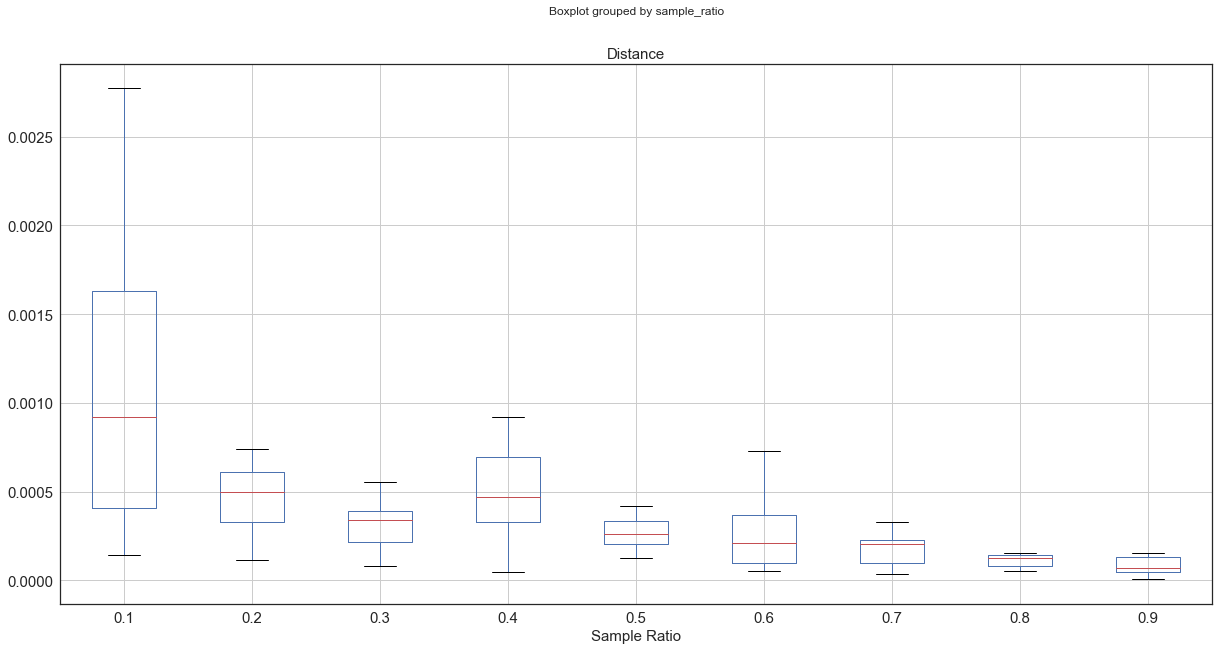

In [367]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.spatial import distance

def _transform(df):
    for col in df.columns:
        if df[col].dtypes == 'object':
            df[col] = LabelEncoder().fit_transform(df[col])
    return df

def _pca(df):
    N = min(df.shape[0], df.shape[1], 2)
    from sklearn.decomposition import PCA
    pca = PCA(n_components = N)
    return pca.fit_transform(df.transpose())

def _distance(df):
    ret_distance = []
    cols = [col for col in df.columns if col not in ['Unnamed: 0']]
    test_all = _transform(df[cols].copy())
    for ining in tqdm(range(10)):
        for ratio in (np.arange(0.1, 1, 0.1)):
            sample_df = df[cols].sample(frac = ratio)
            test_sample = _transform(sample_df.copy())
            norm = MinMaxScaler()
            _test_all    = norm.fit_transform(_pca(test_all)).flatten()
            _test_sample = norm.fit_transform(_pca(test_sample)).flatten()
            ret_distance.append({
                "ining"        : ining,
                "sample_ratio" : ratio,
                "distance"     : distance.euclidean(_test_all, _test_sample)
            })
    return ret_distance

## graph
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

ret_distance = _distance(df)
r = pd.DataFrame(ret_distance)
_, ax = plt.subplots(figsize = (20, 10))
r[['sample_ratio', 'distance']].boxplot(by = 'sample_ratio', ax = ax)
ax.set_xlabel("Sample Ratio", size = 15)
ax.set_title("Distance", size = 15)
r.groupby('sample_ratio').distance.mean()

## 3) 이 두 개의 메트릭을 결합해서, 최적의 샘플링 비율을 찾아보는 시도를 해보는 거에요

- 1, 2번 두 메트릭은 작을 수록 좋습니다.
- 게다가 sample ratio 역시 작을 수록 좋죠
- 즉, 이렇게 메트릭을 만들어 보는 겁니다.

$${{argmin}}\frac{Divergence + Distance}{w * (1- Sample Ratio)}$$

- 여기서 w 는 샘플링 수를 더 줄이고 싶을 때, 줄 수 있는 weight 정보가 될 수 있을 겁니다.
- 뭔가 샘플링 수를 줄이는 데에 더 비중을 두고 싶군요. 그래서 w = 2 로 셋업하고 진행해봅시다.

### 이 메트릭에 의거하면, adult 파일의 적당한 샘플링비율은 .9 이군요

- 흑, 슬픕니다

In [368]:
r_1 = pd.DataFrame(ret).groupby('sample_ratio').kl_div.mean()
r_2 = pd.DataFrame(ret_distance).groupby('sample_ratio').distance.mean()
t   = (r_1 + r_2).reset_index().rename(columns = {0 : 'div_dis'})
t['metric'] = t.div_dis / (2 * (1 - t.sample_ratio))
t.sort_values('metric')

,sample_ratio,div_dis,metric
8,0.9,0.003591,0.017953
7,0.8,0.007713,0.019282
6,0.7,0.012588,0.020979
5,0.6,0.018461,0.023076
4,0.5,0.025783,0.025783
3,0.4,0.035417,0.029514
2,0.3,0.048470,0.034621
1,0.2,0.068457,0.042785
0,0.1,0.107863,0.059924


## 4) 다른 파일도 똑같은 결론을 낼까요?

- 두 번째로 큰 파일인 coil2000, magic, spambase, twonorm 을 가지고 실험을 똑같이 해보았습니다.
- 정의한 메트릭으로는 각각 0.4, 0.8, 0.2의 비율이 적합하다고 나오는 군요.

In [391]:
import pandas as pd
df_a = pd.read_csv("./binary/coil2000.csv", sep = ",", header = 0, error_bad_lines = False)
df_b = pd.read_csv("./binary/magic.csv", sep = ",", header = 0, error_bad_lines = False)
df_c = pd.read_csv("./binary/spambase.csv", sep = ",", header = 0, error_bad_lines = False)
df_d = pd.read_csv("./binary/twonorm.csv", sep = ",", header = 0, error_bad_lines = False)

print("coil2000' shape : {}, magic' shape : {}, spambase' shape : {}, twonorm' shape : {}"\
      .format(df_a.shape, df_b.shape, df_c.shape, df_d.shape))

coil2000' shape : (9822, 87), magic' shape : (19020, 12), spambase' shape : (4597, 59), twonorm' shape : (7400, 22)


## 오!, 다른 결론을 내는 군요

In [392]:
def evaluate(df):
    ret          = _divergence(df)
    ret_distance = _distance(df)
    r_1 = pd.DataFrame(ret).groupby('sample_ratio').kl_div.mean()
    r_2 = pd.DataFrame(ret_distance).groupby('sample_ratio').distance.mean()
    t   = (r_1 + r_2).reset_index().rename(columns = {0 : 'div_dis'})
    t['metric'] = t.div_dis / (2 * (1 - t.sample_ratio))
    print(t.sort_values('metric'))

evaluate(df_a); evaluate(df_b); evaluate(df_c); evaluate(df_d)

  0%|          | 0/10 [00:00<?, ?it/s]

   sample_ratio   div_dis    metric
4           0.5  0.043956  0.043956
2           0.3  0.067652  0.048323
3           0.4  0.059942  0.049952
6           0.7  0.030571  0.050951
7           0.8  0.023384  0.058459
5           0.6  0.050713  0.063391
8           0.9  0.014528  0.072639
0           0.1  0.139640  0.077578
1           0.2  0.357461  0.223413


  0%|          | 0/10 [00:00<?, ?it/s]

   sample_ratio   div_dis    metric
8           0.9  0.079130  0.395651
7           0.8  0.167428  0.418571
6           0.7  0.266542  0.444236
5           0.6  0.374926  0.468657
4           0.5  0.500303  0.500303
3           0.4  0.673776  0.561480
2           0.3  0.883920  0.631372
1           0.2  1.178520  0.736575
0           0.1  1.749789  0.972105


  0%|          | 0/10 [00:00<?, ?it/s]

   sample_ratio   div_dis    metric
7           0.8  0.088225  0.220563
5           0.6  0.212878  0.266098
2           0.3  0.423263  0.302331
6           0.7  0.185260  0.308766
3           0.4  0.434884  0.362403
0           0.1  0.712398  0.395777
1           0.2  0.645342  0.403339
4           0.5  0.415850  0.415850
8           0.9  0.125469  0.627347


100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

   sample_ratio   div_dis    metric
2           0.3  3.005494  2.146782
1           0.2  3.589069  2.243168
3           0.4  2.753906  2.294921
0           0.1  4.339457  2.410809
4           0.5  2.510318  2.510318
5           0.6  2.139655  2.674569
6           0.7  1.927881  3.213134
7           0.8  1.953249  4.883121
8           0.9  1.586318  7.931588


## 5) 이런 방법으로 '줄인 데이터'와 '줄이기 전 데이터'는 얼마나 비슷할까요?

- 그냥 눈으로 한번 보는 겁니다. (twonorm 파일 기준으로, 변수들의 분포를 뿌려봅시다)
- twonorm 기준으로는 샘플링 비율이 0.3 이 최선이였죠? 이 ratio 를 적용해보는거에요
- 눈으로 보기에는 거의 같군요!

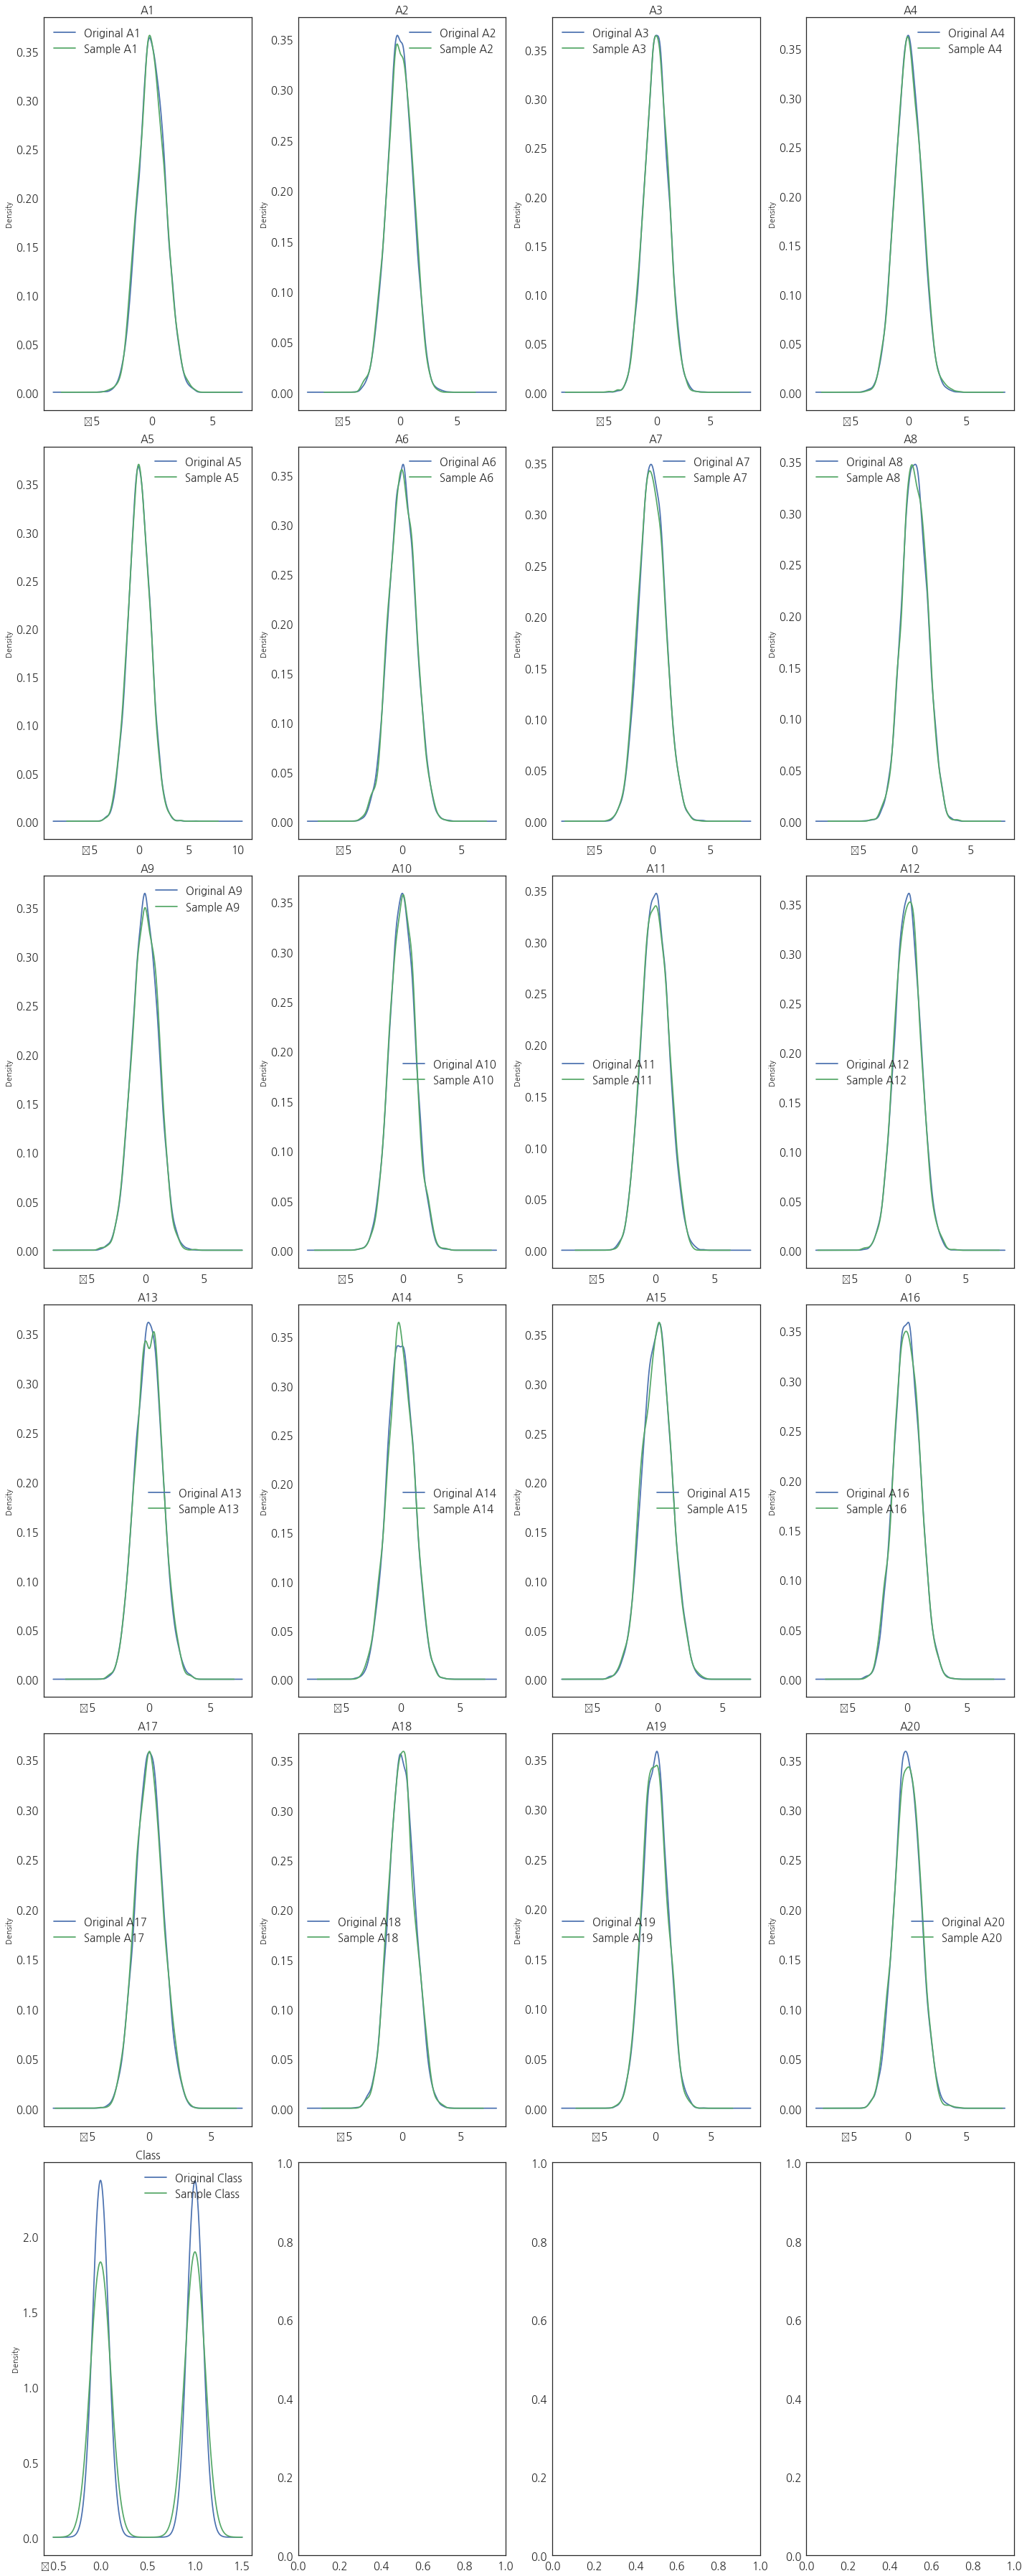

In [395]:
df = df_d
sample_df = df.sample(frac = .3)

from matplotlib import pyplot as plt
%matplotlib inline
_, ax = plt.subplots(6, 4, figsize = (20, 50))
cnt = 0
for col in df.columns:
    if col == 'Unnamed: 0':
        continue
    cnt = cnt + 1
    idx = int((cnt-1) / 4 + 1)
    idy = int((cnt-1) % 4 + 1)
    if df[col].dtypes != 'object':
        df[col].plot(kind = 'kde', ax = ax[idx - 1, idy - 1], label = "Original {}".format(col))
        sample_df[col].plot(kind = 'kde', ax = ax[idx - 1, idy - 1], label = 'Sample {}'.format(col))    
    else:
        df[col].value_counts(normalize = True).plot(kind = 'bar', ax = ax[idx - 1, idy - 1], label = "Original {}".format(col),
                                   position = 0, width = 0.25, color = 'blue')
        sample_df[col].value_counts(normalize = True).plot(kind = 'bar', ax = ax[idx - 1, idy - 1], label = "Sample {}".format(col),
                                          position = 1, width = 0.25, color = 'red')
    ax[idx - 1, idy - 1].set_title(col, size = 15)
    ax[idx - 1, idy - 1].legend()
        
plt.tight_layout()

## 정리하면,

- 1) 데이터가 당최 커서, 빠르게 분석하기가 어려워요.


- 2) 그래서 데이터를 줄이고 싶은데,
    - 줄이기 전 데이터의 특성을 닮은
    - 하지만 많이 줄여지는 방법을 찾고 싶었어요.


- 3) 줄이기 전 데이터와 같다 혹은 다르다. 라고 평가할 수 있는 메트릭이 무엇일까요?
    - 일단 변수 별로 K-L Divergence 를 볼 수 있을 거 같아요.
        - 줄이기 전 데이터와 같다 = 변수 별로 각각의 분포가 있을 텐데, 그 분포들이 샘플링한 집단의 각 변수들의 분포와 비교했을 때 큰 차이가 없다. 를 의미할테니까요.
    - 그리고, 똑같이 N by N 차원으로 Dimension Reduction 을 하고, 그것을 다시 flatten 한 후, 두 벡터 간 Distance 를 구해보면 같다 / 다르다를 측정할 수 있지 않을까요?
        - 만약 두 집단(줄이기 전과 후)의 성질이 비슷하다면, Distance = 0 에 수렴하지 않을까요?
        

- 4) 이 두 가지 메트릭, 그리고 샘플링 비율이 모두 작게 되는 샘플링 비율을 구해보는 거에요. 바로 아래와 같은 식을 마련해서 말이죠.


$${{argmin}\frac{Divergence + Distance}{w * (1- Sample Ratio)}}$$


- 5) 데이터를 넣어보고 위의 식에 의거해서 샘플링 비율을 뽑아봅시다. 그리고 그 샘플링 비율로 데이터를 줄인 집단과 줄이기 전 데이터의 변수 간 분포차이를 그려 보는 겁니다.
    - 분포차이가 크게 다르지 않다라는 것을 확인해볼 수 있었어요.